In [1]:
from __future__ import print_function
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import numpy as np
import os
import progressbar

In [2]:
pickle_file = 'fer2013.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save
    
print('Training set', train_dataset.shape, train_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (28709, 48, 48) (28709,)
Valid set (3589, 48, 48) (3589,)
Test set (3589, 48, 48) (3589,)


In [3]:
def shuffle_data(dataset, labels):
    assert len(dataset) == len(labels)
    p = np.random.permutation(len(dataset))
    return dataset, labels

def augumentData(dataset, labels):
    flipped_data = np.flip(dataset, axis=2)
    return flipped_data, labels

augumented_data, augumented_labels = augumentData(train_dataset, train_labels)
train_dataset = np.concatenate((train_dataset, augumented_data))
train_labels = np.concatenate((train_labels, augumented_labels))

train_dataset, train_labels = shuffle_data(train_dataset, train_labels)

In [4]:
image_size = 48
num_labels = 7
num_channels = 1


def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
    
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (57418, 48, 48, 1) (57418, 7)
Validation set (3589, 48, 48, 1) (3589, 7)
Test set (3589, 48, 48, 1) (3589, 7)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
def batch_norm_conv(x, phase_train):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Variable, true indicates training phase
        scope:       string, variable scope
        affn:      whether to affn-transform outputs
    Return:
        normed:      batch-normalized maps
    Ref: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow/33950177
    """

    phase_train = tf.convert_to_tensor(phase_train, dtype=tf.bool)
    n_out = int(x.get_shape()[3])
    beta = tf.Variable(tf.constant(0.0, shape=[n_out], dtype=x.dtype),
                       name='beta', trainable=True, dtype=x.dtype)
    gamma = tf.Variable(tf.constant(1.0, shape=[n_out], dtype=x.dtype),
                        name='gamma', trainable=True, dtype=x.dtype)

    batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    def mean_var_with_update():
        ema_apply_op = ema.apply([batch_mean, batch_var])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = tf.cond(phase_train,
                                      mean_var_with_update,
                                      lambda: (ema.average(batch_mean), ema.average(batch_var)))
    normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

def batch_norm_fc(x, phase_train):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 2D BD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Variable, true indicates training phase
        scope:       string, variable scope
        affn:      whether to affn-transform outputs
    Return:
        normed:      batch-normalized maps
    Ref: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow/33950177
    """

    phase_train = tf.convert_to_tensor(phase_train, dtype=tf.bool)
    n_out = int(x.get_shape()[1])
    beta = tf.Variable(tf.constant(0.0, shape=[n_out], dtype=x.dtype),
                       name='beta', trainable=True, dtype=x.dtype)
    gamma = tf.Variable(tf.constant(1.0, shape=[n_out], dtype=x.dtype),
                        name='gamma', trainable=True, dtype=x.dtype)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9, name='ema')

    def mean_var_with_update():
        ema_apply_op = ema.apply([batch_mean, batch_var])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = tf.cond(phase_train,

                                      mean_var_with_update,
                                      lambda: (ema.average(batch_mean), ema.average(batch_var)))
    normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [7]:
batch_size = 50

c1_kernel = 5
c2_kernel = 5
c3_kernel = 5

c1_depth = 32
c2_depth = 32
c3_depth = 64
#c4_depth = 256
fc1_nodes = 3072

beta = 0.1
starter_learning_rate = 1e-4
weight_scale = 1e-2
with tf.device('/gpu:0'):
    alexnet_simple = tf.Graph()

    with alexnet_simple.as_default():
        #Input data
        tf_dataset = tf.placeholder(dtype=tf.float32, 
            shape=(batch_size, image_size, image_size, num_channels))
        tf_labels = tf.placeholder(dtype=tf.float32,
            shape=(batch_size, num_labels))

        phase_train = tf.placeholder(dtype=tf.bool)

          # Variables.
        c1_weights = weight_scale * tf.Variable(tf.truncated_normal(
          [c1_kernel, c1_kernel, num_channels, c1_depth], stddev=0.1))
        c1_bias = tf.Variable(tf.zeros([c1_depth]))

        c2_weights = weight_scale * tf.Variable(tf.truncated_normal(
            [c2_kernel, c2_kernel, c1_depth, c2_depth], stddev=0.1))
        c2_bias = tf.Variable(tf.zeros([c2_depth]))

        c3_weights = weight_scale * tf.Variable(tf.truncated_normal(
            [c3_kernel, c3_kernel, c2_depth, c3_depth], stddev=0.1))
        c3_bias = tf.Variable(tf.zeros([c3_depth]))

        #c4_weights = tf.Variable(tf.truncated_normal(
        #    [c3_kernel, c3_kernel, c3_depth, c4_depth], stddev=0.1))
        #c4_bias = tf.Variable(tf.zeros([c4_depth]))

        fc1_weights = weight_scale * tf.Variable(tf.truncated_normal(
                    [image_size //8 * image_size //8 * c3_depth, fc1_nodes], stddev=0.1))
        fc1_bias = tf.Variable(tf.zeros([fc1_nodes]))


        hidden_weights = weight_scale * tf.Variable(tf.truncated_normal(
                [fc1_nodes, num_labels], stddev=0.1))
        hidden_bias = tf.Variable(tf.zeros([num_labels]))


        keep_prob = tf.placeholder(tf.float32)

        def model(data, phase_train):
            with tf.variable_scope('conv1'):
                conv = tf.nn.conv2d(data, c1_weights, [1,1,1,1], padding='SAME') + c1_bias
                conv = batch_norm_conv(conv, phase_train)
                hidden = tf.nn.relu(conv)
                pooled = tf.nn.max_pool(hidden, ksize=[1,3,3,1],
                                        strides=[1,2,2,1], padding='SAME')
            #pooled_norm = tf.nn.local_response_normalization(pooled)

            with tf.variable_scope('conv2'):
                conv = tf.nn.conv2d(pooled, c2_weights, [1,1,1,1], padding='SAME') + c2_bias
                conv = batch_norm_conv(conv, phase_train)
                hidden = tf.nn.relu(conv)
                pooled = tf.nn.avg_pool(hidden, ksize=[1,3,3,1],
                                        strides=[1,2,2,1], padding='SAME')
            #pooled_norm = tf.nn.local_response_normalization(pooled)

            with tf.variable_scope('conv3'):
                conv = tf.nn.conv2d(pooled, c3_weights, [1,1,1,1], padding='SAME') + c3_bias
                conv = batch_norm_conv(conv, phase_train)
                hidden = tf.nn.relu(conv)
                pooled = tf.nn.avg_pool(hidden, ksize=[1,3,3,1],
                                        strides=[1,2,2,1], padding='SAME')

            #conv = tf.nn.conv2d(hidden, c4_weights, [1,1,1,1], padding='SAME')
            #hidden = tf.nn.relu(conv + c4_bias)

            #hidden_norm = tf.nn.local_response_normalization(hidden)

            shape = pooled.get_shape().as_list()

            reshape = tf.reshape(pooled, [shape[0], shape[1] * shape[2] * shape[3]])

            fc1 = tf.matmul(reshape, fc1_weights) + fc1_bias
            fc1 = batch_norm_fc(fc1, phase_train)
            #fc1 = tf.nn.relu(fc1)
            #fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob)
            hidden = tf.cond(keep_prob > 0.1, lambda: tf.nn.dropout(tf.nn.relu(fc1), keep_prob=keep_prob),
                                             lambda: tf.nn.relu(fc1))

            return tf.matmul(hidden, hidden_weights) + hidden_bias           

        logits = model(tf_dataset, phase_train)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_labels))

        l2_loss = beta * ( tf.nn.l2_loss(c1_weights) + tf.nn.l2_loss(c1_bias) +
                       tf.nn.l2_loss(c2_weights) + tf.nn.l2_loss(c2_bias) +
                       tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_bias) +
                       tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(hidden_bias) +
                       tf.nn.l2_loss(c3_weights) + tf.nn.l2_loss(c3_bias) 
                       #tf.nn.l2_loss(c4_weights) + tf.nn.l2_loss(c4_bias)  
                     )

        # global_step = tf.Variable(0, trainable=False)

        #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
        #                                           1000, 0.96, staircase=True)

        optimizer = tf.train.AdamOptimizer(starter_learning_rate).minimize(loss+l2_loss)

        prediction = tf.nn.softmax(logits)

        loss_summary = tf.summary.scalar("loss", loss)

        saver = tf.train.Saver()

        acc_placeholder = tf.placeholder(dtype=tf.float32)
        acc_summary = tf.summary.scalar("accuracy", acc_placeholder)             

In [52]:
num_steps = 240001
model_name = 'tang4'
train_writer = tf.summary.FileWriter('./summary/'+ model_name+'/train', graph=alexnet_simple)

valid_writer = tf.summary.FileWriter('./summary/'+model_name+ '/valid', graph=alexnet_simple)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)

with tf.Session(graph=alexnet_simple) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  initial_step = 0

  ## Load saved checkpoint
  ckpt = tf.train.get_checkpoint_state(
    os.path.dirname('./checkpoints/' + model_name + '/checkpoint'))

  if ckpt and ckpt.model_checkpoint_path:
    # Restore from checkpoint
    saver.restore(session, ckpt.model_checkpoint_path)
    initial_step = int(ckpt.model_checkpoint_path.rsplit('-', 1)[1])
    print("Restore from: ", ckpt.model_checkpoint_path)
  else:
    try:
        os.mkdir('./checkpoints/' + model_name)
    except:
        print("It's ok")
    
  def validate(val_dataset, val_labels):
    num_iterations = val_dataset.shape[0] / batch_size
    
    predict_arr = None
    labels_arr = None
    
    for step in range(num_iterations):
        offset = (step * batch_size) % (val_dataset.shape[0] - batch_size)
        batch_data = val_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = val_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_dataset : batch_data, tf_labels : batch_labels, phase_train: False, keep_prob: 0}
        
        predictions, = session.run(
          [prediction], feed_dict=feed_dict)
        if predict_arr is None:
            predict_arr = predictions
            labels_arr = batch_labels
        else:
            predict_arr = np.append(predict_arr, predictions, 0)
            labels_arr = np.append(labels_arr, batch_labels, 0)
    return accuracy(predict_arr, labels_arr)    
        
           
  #bar = progressbar.ProgressBar(redirect_stdout=True)
  for step in range(initial_step, num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_dataset : batch_data, tf_labels : batch_labels, phase_train: True, keep_prob: 0.8}
    _, l, predictions, = session.run(
      [optimizer, loss, prediction], feed_dict=feed_dict)
    
    #if (step > 0 and step % 100 == 0):
    #  summ = session.run([summary], feed_dict=feed_dict)
    #  train_writer.add_summary(valid_summ, step)
    #  train_writer.add_summary(train_summ, step)
    
    if (step % 100 == 0):  
      #summ = session.run([merged], feed_dict=feed_dict)
      train_writer.add_summary(loss_summary.eval(feed_dict=feed_dict), step)
        
    if (step % 200 == 0):  
        
      #valid_predict = session.run([valid_prediction], feed_dict=feed_dict)
      train_acc = accuracy(predictions, batch_labels)
      valid_acc = validate(valid_dataset[:100], valid_labels[:100])
    
      train_writer.add_summary(acc_summary.eval(feed_dict={acc_placeholder: valid_acc}), step)
      valid_writer.add_summary(acc_summary.eval(feed_dict={acc_placeholder: train_acc}), step)
     
    if (step % 1000 == 0):  
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % train_acc)
      print('------ Validation accuracy: %.1f%%' % valid_acc)
      test_acc = validate(test_dataset[:500], test_labels[:500])
      print('------ Test accuracy: %.1f%%' % test_acc)
    
    
      
    if (step % 5000 == 0):
        saver.save(session, './checkpoints/' + model_name + '/' + model_name, global_step=step)
        
    #bar.update(float(step-initial_step) / (num_steps - initial_step) * 100)
        
  #test_predict = session.run([test_prediction], feed_dict=feed_dict)
  print('====== Public Test accuracy: %.1f%%' % validate(test_dataset, test_labels))
  print('====== Private Test accuracy: %.1f%%' % validate(valid_dataset, valid_labels))
  #saver.save(session, './checkpoints/' + model_name, global_step=num_steps)
  session.close()


train_writer.close()
valid_writer.close()

Initialized
Restore from:  ./checkpoints/tang4/tang4-200000
Minibatch loss at step 200000: 0.028389
Minibatch accuracy: 100.0%
------ Validation accuracy: 62.0%
------ Test accuracy: 61.0%
Minibatch loss at step 201000: 0.042379
Minibatch accuracy: 100.0%
------ Validation accuracy: 60.0%
------ Test accuracy: 59.4%
Minibatch loss at step 202000: 0.060651
Minibatch accuracy: 100.0%
------ Validation accuracy: 66.0%
------ Test accuracy: 58.2%
Minibatch loss at step 203000: 0.038170
Minibatch accuracy: 100.0%
------ Validation accuracy: 60.0%
------ Test accuracy: 58.6%
Minibatch loss at step 204000: 0.048120
Minibatch accuracy: 100.0%
------ Validation accuracy: 66.0%
------ Test accuracy: 61.0%
Minibatch loss at step 205000: 0.038940
Minibatch accuracy: 100.0%
------ Validation accuracy: 66.0%
------ Test accuracy: 59.8%
Minibatch loss at step 206000: 0.040198
Minibatch accuracy: 100.0%
------ Validation accuracy: 60.0%
------ Test accuracy: 59.6%
Minibatch loss at step 207000: 0.0435

Initialized
Restore from:  ./checkpoints/tang4/tang4-240000
iternation:  71
[4 2 4 ..., 2 4 3]
[[227   8  47  45  66  12  59]
 [ 11  33   4   3   3   0   2]
 [ 47   5 215  27  86  51  60]
 [ 17   0  18 730  36  24  57]
 [ 66   2  77  50 321  13 118]
 [ 11   2  29  19  17 321  11]
 [ 31   1  38  59 104  13 354]]


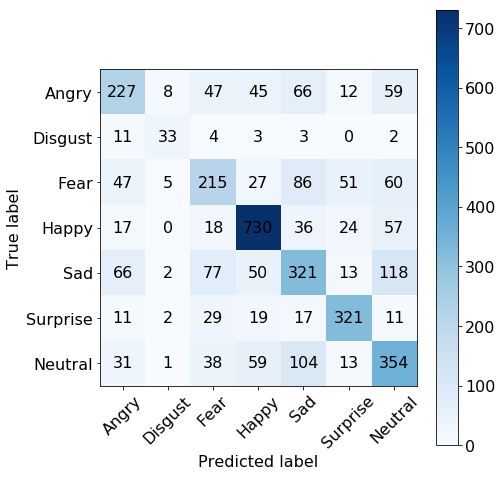

In [57]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
model_name = 'tang4'
def predict(sesson, val_dataset, val_labels):
    num_iterations = val_dataset.shape[0] / batch_size

    print('iternation: ', num_iterations)
    predict_arr = None
    labels_arr = None

    for step in range(num_iterations):
        offset = (step * batch_size) % (val_dataset.shape[0] - batch_size)
        batch_data = val_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = val_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_dataset : batch_data, tf_labels : batch_labels, phase_train: False, keep_prob: 0}

        predictions, = session.run(
          [prediction], feed_dict=feed_dict)
        if predict_arr is None:
            predict_arr = predictions
            labels_arr = batch_labels
        else:
            predict_arr = np.append(predict_arr, predictions, 0)
            labels_arr = np.append(labels_arr, batch_labels, 0)
    
    return np.argmax(predict_arr, 1), np.argmax(labels_arr, 1)

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
with tf.Session(graph=alexnet_simple) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  initial_step = 0

  ## Load saved checkpoint
  ckpt = tf.train.get_checkpoint_state(
    os.path.dirname('./checkpoints/' + model_name + '/checkpoint'))

  if ckpt and ckpt.model_checkpoint_path:
    # Restore from checkpoint
    saver.restore(session, ckpt.model_checkpoint_path)
    print("Restore from: ", ckpt.model_checkpoint_path)
    
    y_pred, y_true = predict(session, test_dataset, test_labels)
    print(y_pred)
    print(confusion_matrix(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)
    
  else:
    print ('Cannot find saved model')

    

In [58]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,7)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,7)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,7) if j != i])
    fp = sum([cm[j,i] for j in range(0,7) if j != i])
    tn = sum([cm[i,j] for j in range(0,7) for i in range(0,7)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [59]:

# private test set
for emotion in labels:
    print (emotion.upper())
    print ('   acc = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print ('  prec = {}'.format(class_precision(y_true, y_pred, emotion)))
    print ('recall = {}\n'.format(class_recall(y_true, y_pred, emotion)))

ANGRY
   acc = 0.881690140845
  prec = 0.553658536585
recall = 0.489224137931

DISGUST
   acc = 0.988450704225
  prec = 0.647058823529
recall = 0.589285714286

FEAR
   acc = 0.862253521127
  prec = 0.502336448598
recall = 0.437881873727

HAPPY
   acc = 0.9
  prec = 0.782422293676
recall = 0.827664399093

SAD
   acc = 0.820281690141
  prec = 0.507109004739
recall = 0.496136012365

SURPRISE
   acc = 0.943098591549
  prec = 0.739631336406
recall = 0.782926829268

NEUTRAL
   acc = 0.844225352113
  prec = 0.535552193646
recall = 0.59



In [60]:
from sklearn.metrics import classification_report
print (classification_report(y_true, y_pred, target_names=labels))

             precision    recall  f1-score   support

      Angry       0.55      0.49      0.52       464
    Disgust       0.65      0.59      0.62        56
       Fear       0.50      0.44      0.47       491
      Happy       0.78      0.83      0.80       882
        Sad       0.51      0.50      0.50       647
   Surprise       0.74      0.78      0.76       410
    Neutral       0.54      0.59      0.56       600

avg / total       0.61      0.62      0.62      3550

